# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, asc, when, datediff
from pyspark.sql.types import StringType , IntegerType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import col, split, countDistinct
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql import Window
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler, IndexToString
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.sql.types import *
from pyspark.sql.types import FloatType

In [2]:
spark = SparkSession.builder.appName("try").getOrCreate()

In [3]:
spark

In [4]:
# create a Spark session
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'try'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1688781020345'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '19804'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host',
  'b52b35ccbdd9de6086ae4057c9035f258c55f508-697bf8c5b9-fwlww')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json("mini_sparkify_event_data.json")

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
print("Dastaset contains {} rows, {} columns".format(df.count(), len(df.columns)))

Dastaset contains 286500 rows, 18 columns


In [8]:
df.show(5) # difference btw df.take() and df.show()

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [37]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [38]:
# to get actual statistyic
df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|         

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### 2.1 Exploring Data Understanding each feature

In [39]:
def summary_df(df):
    '''
    Input: Dataframe
    Output: Gives basic summary like Number of Nulls, and description
    '''
    counts = df.count()
    df_summary = pd.DataFrame(columns = ['Feature','#Nulls','%Nulls', "description"])
    description=["artist name","user's authentication","user's first name", "gender f or m","item count","user last name",
                "length of the song in seconds","plan: free or paid", "user's location","request method","page : various options",
                 "resgistration timestamp","session id","song name","status","timestamp of event","user's browser",
                 "user unique Id"]
    i=0
    for column_name in df.columns:
        null_count = df.where(col(column_name).isNull()).count()
        df_summary.loc[i] = [column_name,null_count,(counts-null_count)/counts, description[i]]
        i +=1
    print(df_summary)  

In [40]:
summary_df(df)

          Feature #Nulls    %Nulls                    description
0          artist  58392  0.796188                    artist name
1            auth      0  1.000000          user's authentication
2       firstName   8346  0.970869              user's first name
3          gender   8346  0.970869                  gender f or m
4   itemInSession      0  1.000000                     item count
5        lastName   8346  0.970869                 user last name
6          length  58392  0.796188  length of the song in seconds
7           level      0  1.000000             plan: free or paid
8        location   8346  0.970869                user's location
9          method      0  1.000000                 request method
10           page      0  1.000000         page : various options
11   registration   8346  0.970869        resgistration timestamp
12      sessionId      0  1.000000                     session id
13           song  58392  0.796188                      song name
14        

In [41]:
# What are the possible different authorizations
print(df.select("auth").dropDuplicates().show())

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

None


In [42]:
#Gender can be female or male - give counts
df.select("gender").groupby("gender").count().show()
#We see that lot of nulls are coming - we can see from above this matches number of missing values in first_name and last_name 
# maybe user_id is not defined properly let's explore

+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+



In [43]:
# on exploring we see empty in null
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [44]:
#we can see there are lot of empty userId 
# Possible reason is that these people are those who have not created an account yet and just exploring services as guest
# For our analysis as they haven't joind yet lets remove these people 
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [45]:
# 8346 records gets removed
df.count() - df_clean.count()
# basically it means they are not nulls must have empty string lets remove those as well

0

In [46]:
df_clean = df_clean.filter(df_clean["userId"] != "")

In [47]:
# the number of rows dropped is equal to 8346 which matches most of the missing nulls in our dataset
df.count() - df_clean.count()

8346

In [48]:
# They are only 3 status 200, 307, 400 - Need to figuire out what they refer to
df_clean.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [49]:
df_clean.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [50]:
# Can extract states from this to analyze
df_clean.select("location").dropDuplicates().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [51]:
# Maybe refer to requesting songs/pages etc
df_clean.select("method").dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [52]:
#Lot of options can be useful features to analyze if customer liked it or not 
df_clean.select("page").dropDuplicates().show(100)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [53]:
df_clean.select("userAgent").dropDuplicates().show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Maci...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Maci...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (iPh...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (comp...|
|Mozilla/5.0 (comp...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [54]:
# unique vaue of auth
df_clean.select("auth").dropDuplicates().sort("auth").show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [55]:
# Notice both guests and logged out people have been removed from the data (Need to think about this)

### 2.2 EDA & Data Transformations

In [56]:
# how many songs users listening in particular hour(need to convert timestamps to datetime from epoch time - need to create function)
#udf - User Defined Function
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)

In [57]:
#adding new column "hour" to our dataframe
df_clean = df_clean.withColumn("hour",get_hour(df_clean.ts)) 

In [58]:
df_clean.select("hour").dropDuplicates().show()

+----+
|hour|
+----+
|   7|
|  15|
|  11|
|   3|
|   8|
|  22|
|  16|
|   0|
|   5|
|  18|
|  17|
|   6|
|  19|
|  23|
|   9|
|   1|
|  20|
|  10|
|   4|
|  12|
+----+
only showing top 20 rows



In [59]:
song_in_hour = df_clean.filter(df.page =="NextSong").groupby(df_clean.hour).count().orderBy(df_clean.hour.cast("float"))

In [60]:
song_in_hour_pd = song_in_hour.toPandas()
song_in_hour_pd.hour = pd.to_numeric(song_in_hour_pd.hour)

So around 3pm to 5pm is the best time to push incentives on customer's app

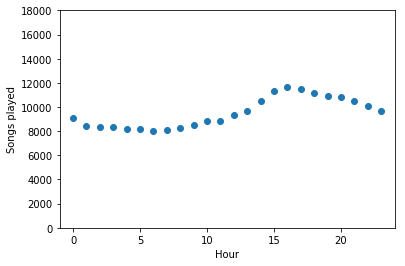

In [61]:
# The variation is almost constant but peaks after 3 pm til about 8 pm
# So around 3pm to 5pm is the best time to push incentives on customer's app
plt.scatter(song_in_hour_pd["hour"], song_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 *15000)
plt.xlabel("Hour")
plt.ylabel("Songs played");

Adding state feature

In [62]:
df_clean = df_clean.withColumn("state", split(df_clean["location"], ",")[1])

transfrom regsitration time

In [63]:
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y"))

In [64]:
df_clean = df_clean.withColumn("ts_date",get_date("ts")) 
#df_clean = df_clean.withColumn("ts_date", to_date(df_clean["ts_date"], "MM-dd-yyyy"))

In [65]:
df_clean = df_clean.withColumn("registration_date",get_date("registration"))
df_clean = df_clean.withColumn("registration_date", to_date(df_clean["registration_date"], "MM-dd-yyyy"))

In [66]:
df_clean.select("ts_date").dtypes

[('ts_date', 'string')]

### Defining CHURN 

In [67]:
# ADD  a column if CHURN THEN 1 else 0 - when users cancelled their plans
# Identified by page - Cancellation Confirmation

In [68]:
df.select("page").dropDuplicates().show(30)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [69]:
## Very Importsnt results - Nukber of customers who have thought about downgrading are 154 but who actually did are only 63

In [70]:
df_clean.filter(df_clean["page"] == "Submit Downgrade").dropDuplicates().count()

63

In [71]:
df_clean.select("userId").filter(df_clean["page"] == "Downgrade").dropDuplicates().count()

154

In [72]:
downgrade = udf(lambda x: 1 if x=="Submit Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("user_downgrade",downgrade("page"))

In [73]:
# For now based on observing data although both custiomers who downgraded and customers who cancelled lead to loass in revenue
# but for this analysis will consider chuirn as those customers who canceled
# will think about including downgraded in next analysis (because if various complexitiesd identified))

In [74]:
canceled = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
df_clean = df_clean.withColumn("user_churned",canceled("page"))

In [75]:
# df_clean = df_clean.withColumn("rev_loss", when((df_clean.user_downgrade == 1) | (df_clean.user_canceled == 1), 1).otherwise(0))
# df_clean.columns

In [76]:
# a = df_clean.select("userId").filter(df_clean["user_canceled"] == 1).dropDuplicates()
# #a.show()
# b = df_clean.select("userId").filter(df_clean["user_downgrade"] == 1).dropDuplicates()
# b.show()
# c =df_clean.select("userId").filter(df_clean["user_churned"] == 1).dropDuplicates()
# ans = c.select('userId').rdd.flatMap(lambda x: x).collect()

In [77]:
# df_clean = df_clean.withColumn('user_churned', when(col('userId').isin(ans), 1).otherwise(0))

In [78]:
# df_clean.select("userId").filter(df_clean["user_churned"] == 1).dropDuplicates().count()

In [79]:
# df_clean.select("userId").filter(df_clean["user_churned"] == 0).dropDuplicates().count()

In [80]:
# print("downgraded their service {}".format(df_clean.select("userId").filter(df_clean["user_downgrade"] == 1).dropDuplicates().count()))
# print("cancelled their services {}".format(df_clean.select("userId").filter(df_clean["user_canceled"] == 1).dropDuplicates().count()))
# print("total users churned {}".format(df_clean.select("userId").filter(df_clean["user_churned"] == 1).dropDuplicates().count()))

In [81]:
df_clean.select("userId").filter(df_clean["user_churned"] == 1).dropDuplicates().count()

52

In [82]:
df_clean.select("userId").filter(df_clean["user_churned"] == 0).dropDuplicates().count()

225

In [83]:
df_clean.select("userId").dropDuplicates().count()

225

In [84]:
df_clean.select(["userId","user_churned"]).dropDuplicates().count()

277

In [85]:
a = df_clean.select("userId").filter(df_clean["user_churned"] == 0)
b= df_clean.select("userId").filter(df_clean["user_churned"] == 1)
c = a.join(b,"userId","inner")
c.dropDuplicates().show()

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|100021|
|    29|
|    73|
|    87|
|     3|
|    28|
|100022|
|100025|
|300007|
|100006|
|    18|
|    70|
|100005|
|    17|
|100007|
+------+
only showing top 20 rows



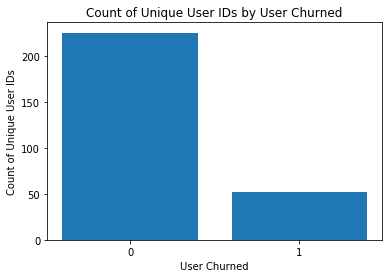

In [86]:
import pyspark.sql.functions as F

# Group by "user_churned" and count distinct "userId" values
grouped_df = df_clean.groupBy("user_churned").agg(F.countDistinct("userId").alias("unique_user_count"))

# Convert the DataFrame to Pandas for plotting
pandas_df = grouped_df.toPandas()

# Plot the bar chart
plt.bar(pandas_df["user_churned"], pandas_df["unique_user_count"])
plt.xlabel("User Churned")
plt.ylabel("Count of Unique User IDs")
plt.title("Count of Unique User IDs by User Churned")
plt.xticks([0,1])
plt.show()

In [87]:
df_clean.select("gender").groupby("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



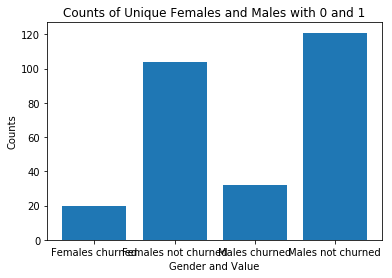

In [88]:
f0 = df_clean.filter((col('user_churned') == 0) & (col('gender') == 'F'))
f1 = df_clean.filter((col('user_churned') == 1) & (col('gender') == 'F'))
m0 = df_clean.filter((col('user_churned') == 0) & (col('gender') == 'M'))
m1 = df_clean.filter((col('user_churned') == 1) & (col('gender') == 'M'))
fc1 = f1.select("userId").distinct().count()
fc0 = f0.select("userId").distinct().count()
mc0 = m0.select("userId").distinct().count()
mc1 = m1.select("userId").distinct().count()
labels = ['Females not churned', 'Females churned', 'Males not churned', 'Males churned']
counts = [fc0,fc1,mc0,mc1]

plt.bar(labels, counts)
plt.xlabel('Gender and Value')
plt.ylabel('Counts')
plt.title('Counts of Unique Females and Males with 0 and 1')
plt.show()

We can see that because male users > female users therefore population of both churned and no-churned is same (Observed from below graph as well)

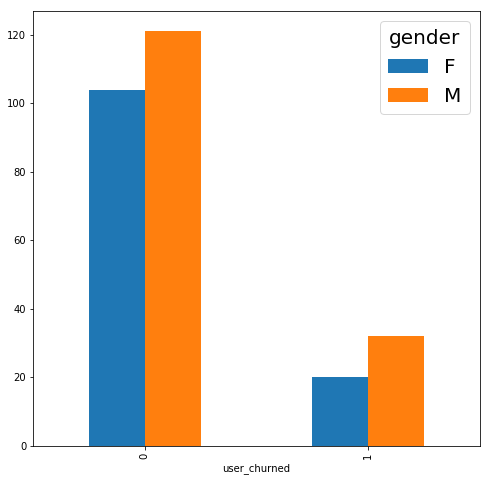

In [89]:
gender_count = df_clean.select('userId','gender','user_churned').dropDuplicates().groupby('gender','user_churned').count().toPandas()
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
gender_count.pivot(index='user_churned', columns='gender', values='count').plot(kind='bar',ax=ax)

In [90]:
# better tpo calcualte % of each genders that churned


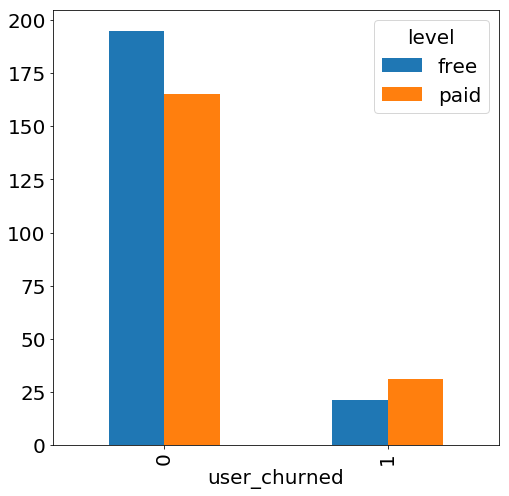

In [91]:
level_count = df_clean.select('userId','level','user_churned').dropDuplicates().groupby('level','user_churned').count().toPandas()
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.rcParams["font.size"] = "20"
level_count.pivot(index='user_churned', columns='level', values='count').plot(kind='bar',ax=ax)

In [92]:
df_clean.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'hour',
 'state',
 'ts_date',
 'registration_date',
 'user_downgrade',
 'user_churned']

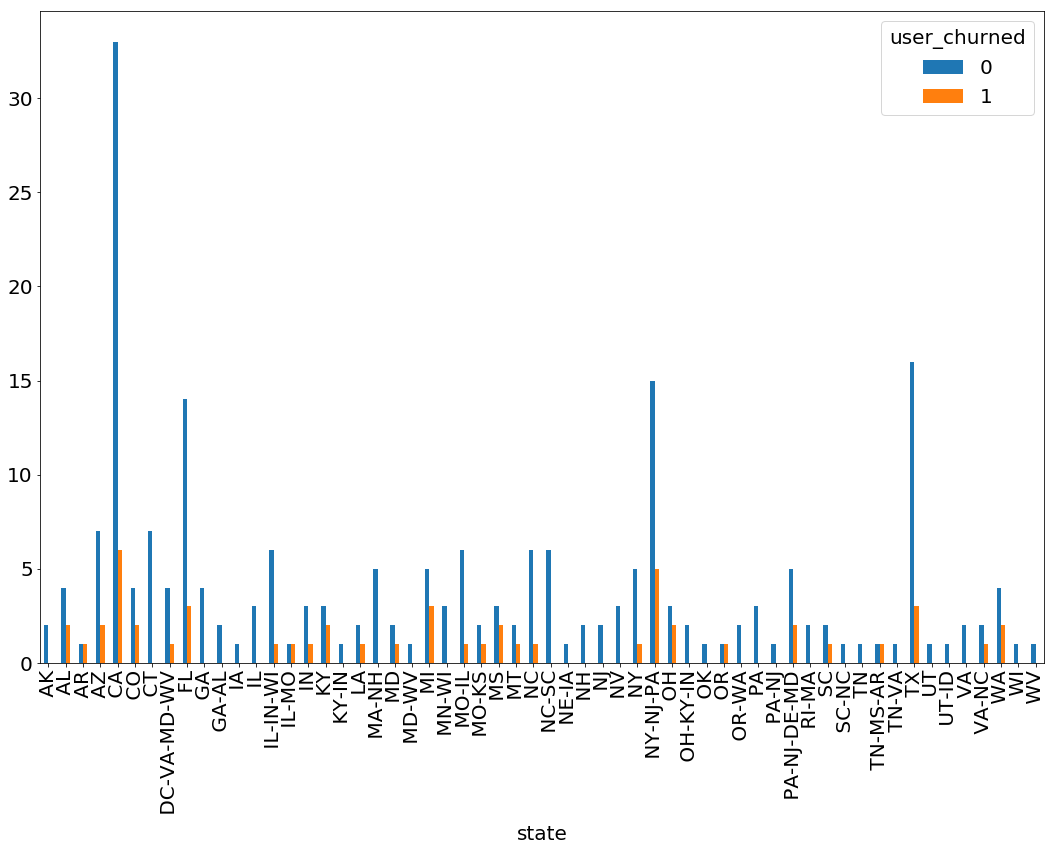

In [93]:
state_count = df_clean.select('userId','state','user_churned').dropDuplicates().groupby('state','user_churned').count().toPandas()
fig = plt.figure(figsize=(18,12))
ax = fig.gca()
#plt.rcParams["font.size"] = "8"
state_count.pivot(index='state', columns='user_churned', values='count').plot(kind='bar',ax=ax)

In [94]:
df_clean.createOrReplaceTempView("df_sql")
#df_clean.select(["sessionId", 'userId','length',"user_churned"]).groupby(["user_id","sessionId","user_churned"]).sum("length").show()
hours_spent = spark.sql('''
          SELECT user_churned, Round(Sum(length)/3600,2) As hours_listened
          FROM df_sql
          GROUP BY user_churned
          ''' 
          )


In [95]:
hours_spent.show()

+------------+--------------+
|user_churned|hours_listened|
+------------+--------------+
|           1|          null|
|           0|       15784.9|
+------------+--------------+



In [96]:
hours_spent = spark.sql('''
          SELECT userId, user_churned, Round(Sum(length)/3600,2) As hours_listened
          FROM df_sql
          WHERE user_churned = 1
          GROUP BY userId, user_churned
          ''' 
          ).show()

+------+------------+--------------+
|userId|user_churned|hours_listened|
+------+------------+--------------+
|100005|           1|          null|
|300007|           1|          null|
|100011|           1|          null|
|100012|           1|          null|
|   101|           1|          null|
|100014|           1|          null|
|200001|           1|          null|
|   105|           1|          null|
|     3|           1|          null|
|100023|           1|          null|
|200017|           1|          null|
|200015|           1|          null|
|    18|           1|          null|
|   125|           1|          null|
|100015|           1|          null|
|100003|           1|          null|
|    87|           1|          null|
|    17|           1|          null|
|    73|           1|          null|
|100025|           1|          null|
+------+------------+--------------+
only showing top 20 rows



In [97]:
session_result = spark.sql('''
          SELECT userId, user_churned , COUNT(sessionId) as cnt_session,SUM(itemInSession) AS sum_items
          FROM df_sql
          GROUP BY userId, user_churned
          ''' 
          )
session_result.createOrReplaceTempView("df_s")
ans = spark.sql('''
          SELECT user_churned, Round(AVG(cnt_session),2),Round(AVG(sum_items),2)
          FROM df_s
          GROUP BY user_churned
          ''' 
          ).show()

+------------+--------------------------+------------------------+
|user_churned|round(avg(cnt_session), 2)|round(avg(sum_items), 2)|
+------------+--------------------------+------------------------+
|           1|                       1.0|                   88.19|
|           0|                   1236.01|               142022.58|
+------------+--------------------------+------------------------+



In [98]:
# Need to add the time_since_registeration
# see for both churn and nin-churn
# Ecplor method part
# Status count per churn group
# etc

# inea chart about how number of usa varies fro paid and free plan
# song count_per churn grpop
# sg count oper week
# song count by hout
# song count by wek days
# song length churn vs non_churn
# count other oage 
#countnw sog pahge
# count niusn son page
#page count per hou

In [99]:
# calcualte time since joining (registration time - max(ts)) for each user


In [100]:
df_clean.createOrReplaceTempView("df_sql")
a = spark.sql('''
         SELECT userId, MAX(user_churned) AS user_churned, MIN(registration_date) AS registration_dt, MAX(ts_date) AS ts_dt
         FROM df_sql
         GROUP BY userID
         ''')

In [101]:
a.createOrReplaceTempView("df2")     
final_days_period = spark.sql('''
                                SELECT userId, user_churned, DATEDIFF(ts_dt,registration_dt)
                                from df2
                             ''').show()

+------+------------+----------------------------------------------+
|userId|user_churned|datediff(CAST(ts_dt AS DATE), registration_dt)|
+------+------------+----------------------------------------------+
|100010|           0|                                          null|
|200002|           0|                                          null|
|   125|           1|                                          null|
|   124|           0|                                          null|
|    51|           1|                                          null|
|     7|           0|                                          null|
|    15|           0|                                          null|
|    54|           1|                                          null|
|   155|           0|                                          null|
|100014|           1|                                          null|
|   132|           0|                                          null|
|   154|           0|             

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [38]:
df = spark.read.json("mini_sparkify_event_data.json")

In [39]:
def clean_data(df):
    '''
    Function that performs data cleaning of Sparkify dataset.
    
    INPUT: 
    df - pyspark dataframe containing Sparkify events
    
    OUTPUT:
    df_new - pyspark dataframe with removed rows with empty 'userId' column and duplicates if any
    '''
    
    # remove rows where userId is empty and duplicated rows
    #df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
    #df_clean = df.filter(df["userId"] != "")
    
    df_clean = df.filter(df["firstName"].isNotNull()).dropDuplicates()
    return df_clean


# def get_date_from_timestamp(df, col_name, new_col_name):
#     '''
#     Function that convert timestamp to date
#     '''
#     get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y"))
#     df.withColumn(new_col_name,get_date(df_clean[col_name])) 
#     df = df.withColumn(new_col_name, to_date(df[col_name], "MM-dd-yyyy"))
#     return df
#     #return df.withColumn(new_col_name, F.to_timestamp(F.col(col_name) / 1000).astype(StringType()))
    
#     #return df.withColumn(new_col_name, F.to_date(F.col(col_name) / 1000).astype(StringType()))

In [40]:
def prepare_dataset(df):
    '''
    Function for preparation of dataset for machine learning models.
    
    INPUT:
    df - initial dataset loaded from json file
    
    OUTPUT:
    df_ml - new dataset prepared for machine learning which
    contains the following columns:
    
    1. userId - initial id of the user
    2. gender - user's gender
    3. days_registered - days since user's registration
    4. last_state - current state of the user
    5. avg_songs_per_day - average songs played per day
    6. last_level - current subscription plan
    7. Thumbsup_proportion - ratio of thumbs up over thumbs down
    8. num_add_friends - number of add friends events
    9. avg_roll_adv_per_day - average number of roll adv played per day
    10. churn_cancellation
    '''
    
    # Clean dataset using clean_data function
    df = clean_data(df)
    
    get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y"))

    df = df.withColumn("ts_date", to_date(get_date(df["ts"]), "MM-dd-yyyy"))
    df = df.withColumn("registration_date", to_date(get_date(df["registration"]), "MM-dd-yyyy"))
    
    # Create column Churn when the event recorded is 'Cancellation Confirmation'. 
    # A value equal to 1 indicates that the user cancelled the subscription.
    churn_cancellation = udf(lambda x: 1 if x=="Cancellation Confirmation" else 0, IntegerType())
    
    df = df.withColumn("churn_cancellation", churn_cancellation("page"))
    
    # Get userId with churn_cancellation == 1
    cancelled_users = df.select(['userId']).where(df.churn_cancellation == 1).groupby('userId').count().toPandas()['userId'].values
    cancelled_users = list(cancelled_users)
    df = df.withColumn('churn_cancellation', when((df.userId).isin(cancelled_users), 1).otherwise(0))
    
    # Convert column gender to numeric: 1 for 'female' and 0 for 'male'
    gender = udf(lambda x: 1 if x=="F" else 0, IntegerType())
    
    df = df.withColumn("gender", gender("gender"))
    
    # Convert column level to numeric: 1 for 'paid' and 0 for 'free'
    
    
    #df = df.withColumn("level", level("level"))
    


    
    # Compute active days as number of days since registration
    # Create dataframe with last timestamp (ts_date) per user
    df_last_ts = df.groupBy('userId').agg(max('ts_date').alias('last_interaction'))
    
    df = df.join(df_last_ts, on='userId').select(df_last_ts['*'], df['*']).withColumn('days_registered', datediff(df_last_ts['last_interaction'], df['registration_date']).cast('float'))
    
    # Create a new column 'date' with format 'yyyy-MM-dd'
    df = df.withColumn('date', date_format('ts_date', 'yyyy-MM-dd').alias('date'))
    
    # Create a new column 'last_state' where the last session was recorded
    #df = df.withColumn("state", substring(df.location, -2, 2))
    #df = df.withColumn('last_state', when(df_last_ts.last_interaction == df.ts_date, df.state))
    ###############################################################################
    #print(df.select("page").dropDuplicates().show())
    ###############################################################################

    return df

In [41]:
ans = prepare_dataset(df)

In [42]:
def build_features(df):
    
    df = prepare_dataset(df)
    # Compute average songs played by day per user
    avg_songs = df.filter(df.page == "NextSong").groupBy('userId',"ts_date").agg({'page':'count'})\
                                        .groupBy("userId").mean().withColumnRenamed("avg(count(page))","avg_songs")\
                                        .withColumn("avg_songs", round("avg_songs", 2))
    avg_songs = avg_songs.select(avg_songs['userId'].alias('songs_userId'), "avg_songs")
    #avg_songs.show()
    
    # Compute the number of thumbs up for user
    thumbs_up = df.filter(df.page == "Thumbs Up").groupBy('userId').agg({'page':'count'})
    thumbs_up = thumbs_up.select(thumbs_up['userId'].alias('thumbsup_userId'), thumbs_up['count(page)'].alias('thumbs_up_count'))
    #thumbs_up.show()
    
    # Compute the number of thumbs down per user
    thumbs_down = df.filter(df.page == "Thumbs Down").groupBy('userId').agg({'page':'count'})
    thumbs_down = thumbs_down.select(thumbs_down['userId'].alias('thumbsdown_userId'), thumbs_down['count(page)'].alias('thumbs_down_count'))
      

    # Compute the number of add friend events per user
    add_friend = df.filter(df.page == "Add Friend").groupBy('userId').agg({'page':'count'})\
                                     .withColumnRenamed("count(page)","num_friends")
    add_friend = add_friend.select(add_friend['userId'].alias('add_friend_userId'), "num_friends")
    
    # Compute the fraction of page 'roll advert'
    avg_roll_adv = df.filter(df.page == "Roll Advert").groupBy('userId',"ts_date").agg({'page':'count'})\
                                        .groupBy("userId").mean().withColumnRenamed("avg(count(page))","avg_roll_advert")\
                                        .withColumn("avg_roll_advert", round("avg_roll_advert", 2))
    avg_roll_adv = avg_roll_adv.select(avg_roll_adv['userId'].alias('roll_adv_userId'), "avg_roll_advert")
    
    # daily help
    dailyHelpVisit = df.filter(df.page == "Help").groupBy('userId',"ts_date").agg({'page':'count'})\
                                        .groupBy("userId").mean().withColumnRenamed("avg(count(page))","help_visit")
    dailyHelpVisit = dailyHelpVisit.select(dailyHelpVisit['userId'].alias('help_userId'), "help_visit")
    
    #daily error
    dailyErrorVisit = df.filter(df.page == "Error").groupBy('userId',"ts_date").agg({'page':'count'})\
                                        .groupBy("userId").mean().withColumnRenamed("avg(count(page))","error_visit")
    
    dailyErrorVisit = dailyErrorVisit.select(dailyErrorVisit['userId'].alias('error_userId'), "error_visit")                                 
    #total playlist
    num_playlist = df.filter(df.page == "Add to Playlist").groupBy('userId').agg({'page':'count'})\
                                        .withColumnRenamed("count(page)","total_playlist")\
                                        .withColumn("total_playlist", round("total_playlist", 2))
    num_playlist = num_playlist.select(num_playlist['userId'].alias('playlist_userId'), "total_playlist")
                  
    #print(df.columns)
    level = udf(lambda x: 1 if x=="paid" else 0, IntegerType())
    levels = df.select(['userId', 'level', 'ts_date'])\
                        .orderBy(desc('ts_date'))\
                        .dropDuplicates(['userId'])\
                        .select(['userId', 'level'])\
                        .withColumn('last_level', level(df['level']).cast(IntegerType()))
    levels = levels.drop('level')
    levels = levels.withColumnRenamed('userId', 'level_userId')
    
    # Combine all the features into a single dataframe
    df_ml = df.select('userId', 'gender', 'churn_cancellation', 'days_registered', 'last_state').dropna().drop_duplicates() \
              .join(avg_songs, avg_songs.songs_userId == df.userId, how='left')\
              .join(levels, levels.level_userId == df.userId, how='left')\
              .join(thumbs_up, thumbs_up.thumbsup_userId == df.userId, how='left') \
              .join(thumbs_down, thumbs_down.thumbsdown_userId == df.userId, how='left') \
              .join(add_friend, add_friend.add_friend_userId == df.userId, how='left') \
              .join(avg_roll_adv, avg_roll_adv.roll_adv_userId == df.userId, how='left') \
              .join(dailyHelpVisit, dailyHelpVisit.help_userId == df.userId, how='left') \
              .join(dailyErrorVisit, dailyErrorVisit.error_userId == df.userId, how='left') \
              .join(num_playlist, num_playlist.playlist_userId == df.userId, how='left') \
              .drop('songs_userId', 'thumbsup_userId', 'thumbsdown_userId', 'add_friend_userId', 'roll_adv_userId', 'help_userId', 'error_userId', 'playlist_userId',"level_userId") \
              .fillna(0)
    
    return df_ml


In [43]:
df_model=build_features(df)

In [44]:
df_model.show()

+------+------+------------------+---------------+----------+---------+----------+---------------+-----------------+-----------+---------------+------------------+------------------+--------------+
|userId|gender|churn_cancellation|days_registered|last_state|avg_songs|last_level|thumbs_up_count|thumbs_down_count|num_friends|avg_roll_advert|        help_visit|       error_visit|total_playlist|
+------+------+------------------+---------------+----------+---------+----------+---------------+-----------------+-----------+---------------+------------------+------------------+--------------+
|100010|     1|                 0|           55.0|        CT|    39.29|         0|             17|                5|          4|           8.67|               1.0|               0.0|             7|
|200002|     0|                 0|           70.0|        WI|    55.29|         1|             21|                6|          4|           1.75|               1.0|               0.0|             8|
|   125|  

In [46]:
df_model.rdd.saveAsPickleFile("df_data3")

In [47]:
df_final = df_model.toPandas()

In [48]:
df_final.head()

,userId,gender,churn_cancellation,days_registered,last_state,avg_songs,last_level,thumbs_up_count,thumbs_down_count,num_friends,avg_roll_advert,help_visit,error_visit,total_playlist
0,100010,1,0,55.0,CT,39.29,0,17,5,4,8.67,1.000000,0.0,7
1,200002,0,0,70.0,WI,55.29,1,21,6,4,1.75,1.000000,0.0,8
2,125,0,1,72.0,TX,8.00,0,0,0,0,1.00,0.000000,0.0,0
3,124,1,0,131.0,NJ,127.47,1,171,41,74,1.00,1.437500,1.2,118
4,51,0,1,20.0,KY,162.38,1,100,21,28,0.00,1.714286,1.0,52


In [49]:
df_final.to_csv("final_data.csv")

##### Key Feures Identified
1. Gender (F/M)                done
2. level (Paid/free)           done      
3. Event count                 
4. Add friend                  done
5. thumbs up proportion        done
6. No. of errors (page count)  done
7. add to playlist             done
8. roll advert                 done
9. location                    done
10. avg help                   done
11. avg mext song              done
12. session count per day      
13. session avg length
14. avg session gap (???)
15. unique song count
16. unique song shares
17. days since registrastion   

In [50]:
df_final=pd.read_csv("final_data.csv")
df_final.head()

,Unnamed: 0,userId,gender,churn_cancellation,days_registered,last_state,avg_songs,last_level,thumbs_up_count,thumbs_down_count,num_friends,avg_roll_advert,help_visit,error_visit,total_playlist
0,0,100010,1,0,55.0,CT,39.29,0,17,5,4,8.67,1.000000,0.0,7
1,1,200002,0,0,70.0,WI,55.29,1,21,6,4,1.75,1.000000,0.0,8
2,2,125,0,1,72.0,TX,8.00,0,0,0,0,1.00,0.000000,0.0,0
3,3,124,1,0,131.0,NJ,127.47,1,171,41,74,1.00,1.437500,1.2,118
4,4,51,0,1,20.0,KY,162.38,1,100,21,28,0.00,1.714286,1.0,52


In [51]:
df_final.shape[0]

225

In [52]:
df_final.churn_cancellation.value_counts()

0    173
1     52
Name: churn_cancellation, dtype: int64

In [53]:
df_final.last_state.value_counts()
# there is large variations and many states have very less customers 
# this is a sample of datasets but most likely same pattern will exost in entire dataset also
# so grouping it into 4 columns - CA, PA, TX, FL, WI, AND OTHERS (FREQUENY LESS THAN 5 )

CA    33
PA    18
TX    16
FL    14
WI    10
IL     9
NC     9
SC     8
CT     7
MD     7
NH     7
AZ     7
IN     6
WV     6
WA     6
AL     6
NY     5
MI     5
GA     4
CO     4
OH     3
NV     3
MS     3
KY     3
NJ     3
VA     3
KS     2
AK     2
IA     2
MT     2
MA     2
LA     2
AR     2
ID     1
UT     1
TN     1
OR     1
OK     1
MO     1
Name: last_state, dtype: int64

In [54]:
state_counts = df_final.last_state.value_counts()

# Define the threshold for grouping states
threshold = 5

# Get the list of states to be grouped as 'Others'
states_to_group = state_counts[state_counts < threshold].index.tolist()

# Replace the states with low counts with 'Others'
df_final.loc[df_final['last_state'].isin(states_to_group), 'last_state'] = 'Others'

# Check the updated value counts after grouping
updated_state_counts = df_final['last_state'].value_counts()
print(updated_state_counts)

Others    46
CA        33
PA        18
TX        16
FL        14
WI        10
IL         9
NC         9
SC         8
NH         7
CT         7
MD         7
AZ         7
WA         6
IN         6
AL         6
WV         6
NY         5
MI         5
Name: last_state, dtype: int64


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


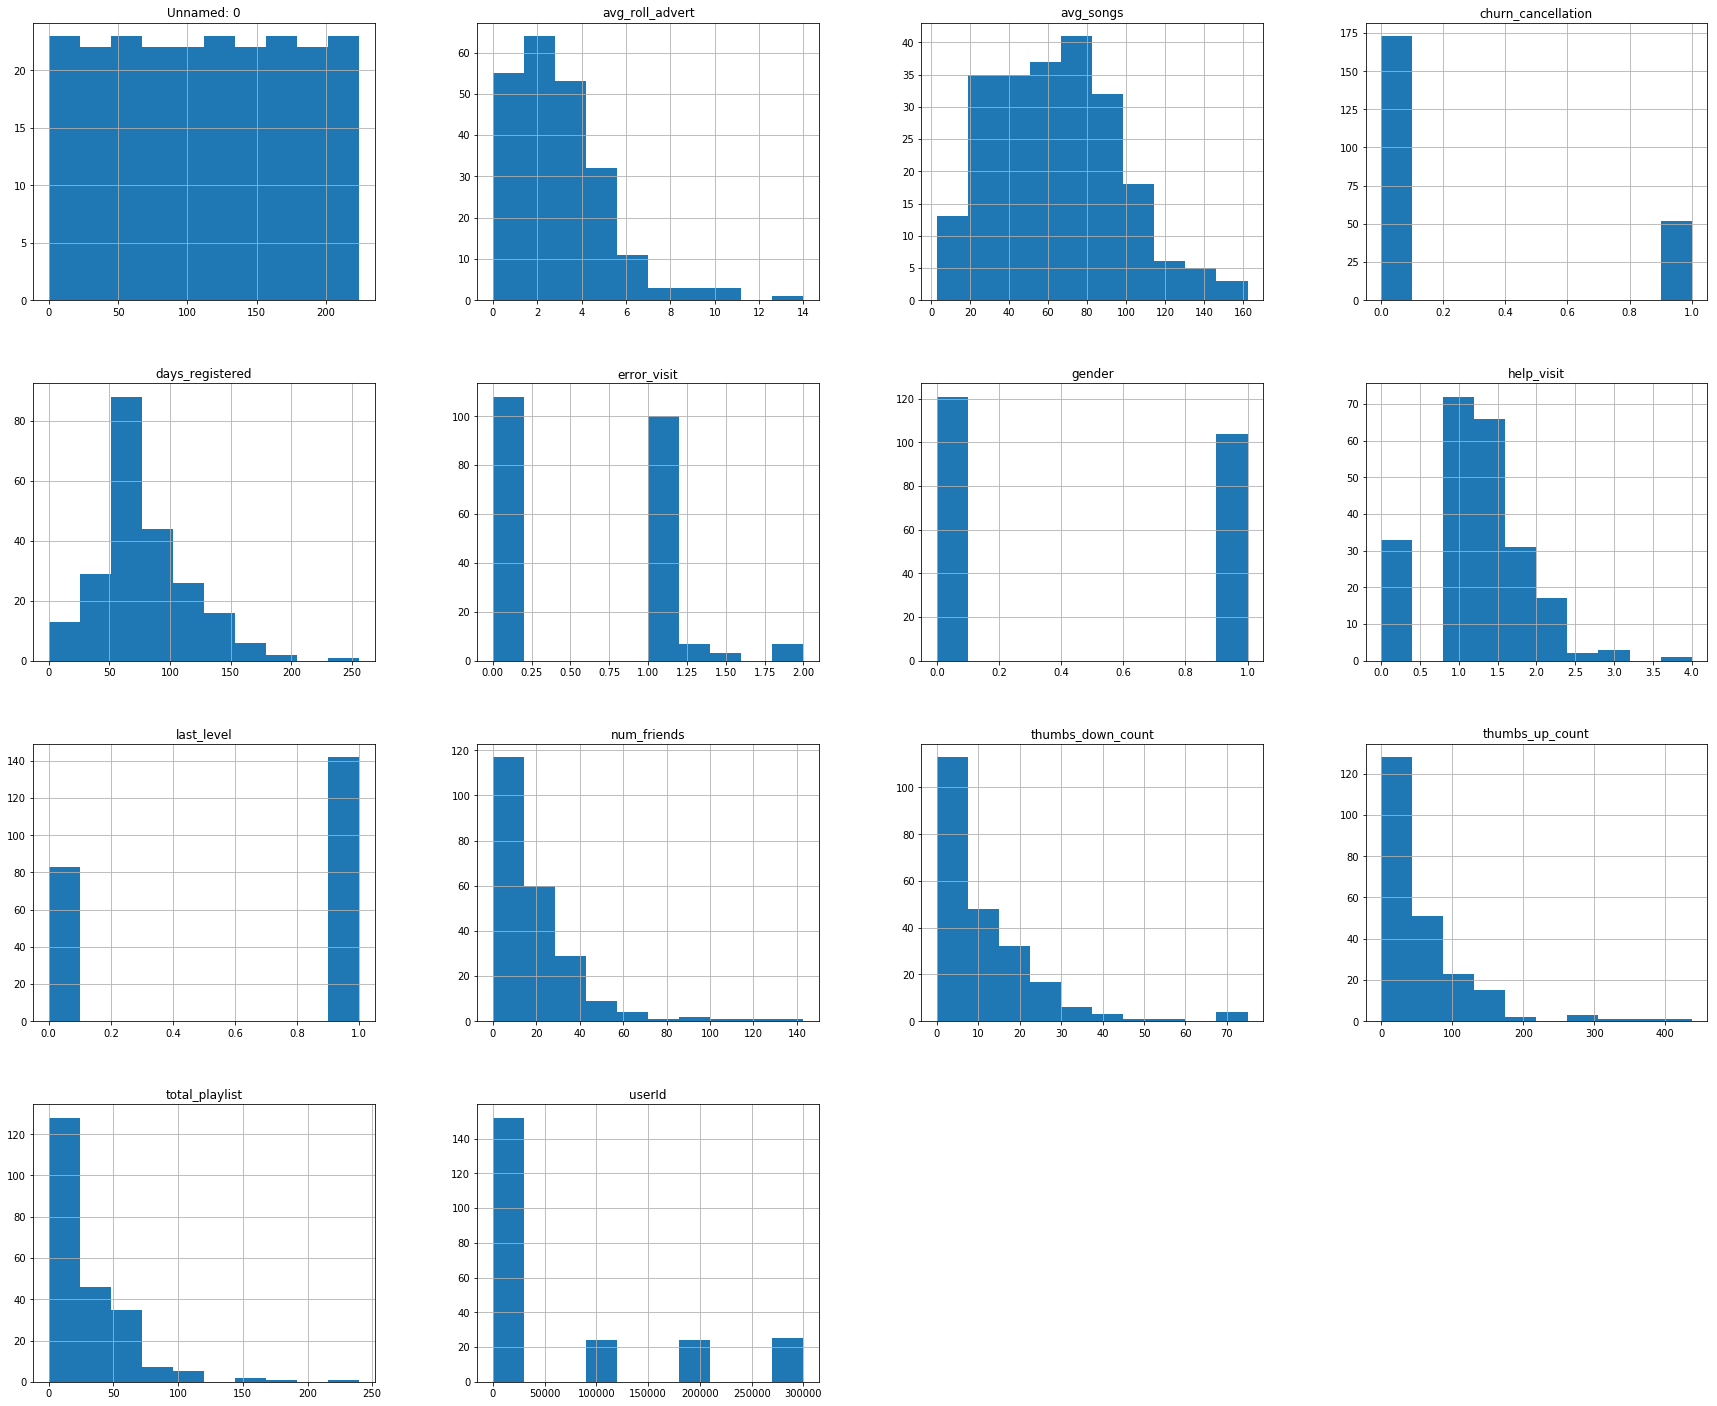

In [55]:
fig = plt.figure(figsize=(30,25))
ax = fig.gca()
h = df_final.hist(ax=ax)

In [56]:
data = df_final.copy()

In [57]:
# ############### Feasture Selection ###############################

# from sklearn.feature_selection import SelectKBest, f_regression
# from sklearn.preprocessing import LabelEncoder

# categorical_column = 'last_state'
# le = LabelEncoder()
# data[categorical_column] = le.fit_transform(data[categorical_column])

# X = data.drop('churn_cancellation', axis=1)
# y = data['churn_cancellation']

# k = 5  # Number of top features to select
# selector = SelectKBest(f_regression, k=k)
# X_new = selector.fit_transform(X, y)

# # Get the selected feature indices
# selected_indices = selector.get_support(indices=True)

# # Get the selected feature names
# selected_features = X.columns[selected_indices]

# # Print the selected features
# print("Selected Features:")
# print(selected_features)

In [58]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OneHotEncoder


# Perform one-hot encoding on the categorical column
categorical_column = 'last_state'
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_data = pd.get_dummies(data, columns=[categorical_column], prefix=[categorical_column])

# Separate the target variable
y = encoded_data['churn_cancellation']
X = encoded_data.drop('churn_cancellation', axis=1)

# Perform feature selection using SelectKBest and f_regression
k = 5  # Number of top features to select
selector = SelectKBest(f_regression, k=k)
X_new = selector.fit_transform(X, y)

# Get the selected feature indices
selected_indices = selector.get_support(indices=True)

# Get the selected feature names
selected_features = X.columns[selected_indices]

# Print the selected features
print("Selected Features:")
print(selected_features)




Selected Features:
Index(['days_registered', 'thumbs_up_count', 'num_friends', 'avg_roll_advert',
       'total_playlist'],
      dtype='object')


In [59]:
encoded_data.columns

Index(['Unnamed: 0', 'userId', 'gender', 'churn_cancellation',
       'days_registered', 'avg_songs', 'last_level', 'thumbs_up_count',
       'thumbs_down_count', 'num_friends', 'avg_roll_advert', 'help_visit',
       'error_visit', 'total_playlist', 'last_state_AL', 'last_state_AZ',
       'last_state_CA', 'last_state_CT', 'last_state_FL', 'last_state_IL',
       'last_state_IN', 'last_state_MD', 'last_state_MI', 'last_state_NC',
       'last_state_NH', 'last_state_NY', 'last_state_Others', 'last_state_PA',
       'last_state_SC', 'last_state_TX', 'last_state_WA', 'last_state_WI',
       'last_state_WV'],
      dtype='object')

In [60]:
data.columns

Index(['Unnamed: 0', 'userId', 'gender', 'churn_cancellation',
       'days_registered', 'last_state', 'avg_songs', 'last_level',
       'thumbs_up_count', 'thumbs_down_count', 'num_friends',
       'avg_roll_advert', 'help_visit', 'error_visit', 'total_playlist'],
      dtype='object')

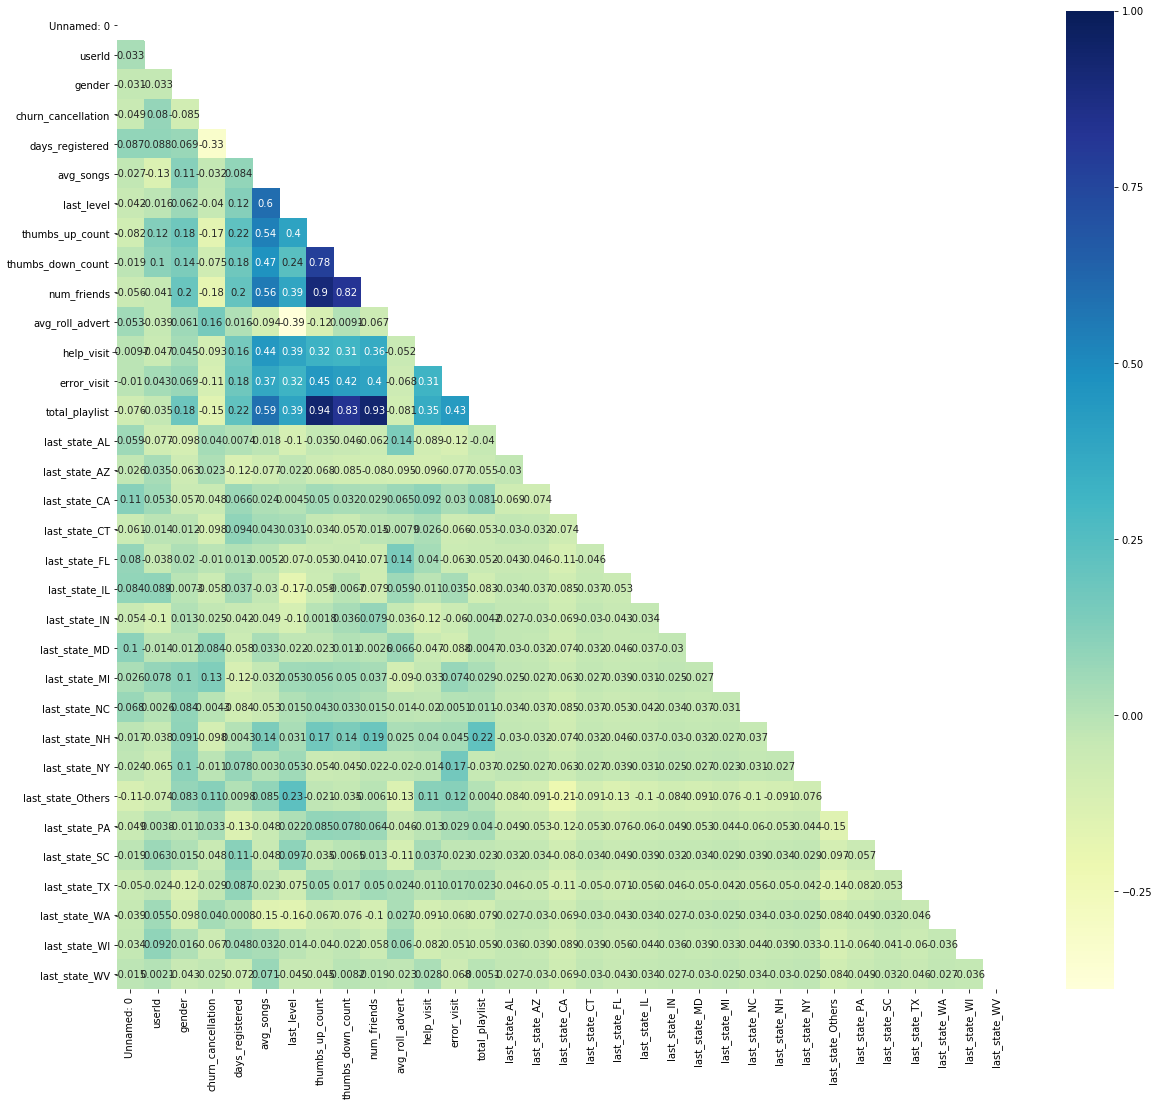

In [61]:
# Check correlation among features

# creating mask
mask = np.triu(np.ones_like(encoded_data.corr()))
 
# plotting a triangle correlation heatmap
plt.clf()
plt.figure(figsize=(20, 18))
dataplot = sns.heatmap(encoded_data.corr(), cmap="YlGnBu", annot=True, mask=mask)

# displaying heatmap
plt.show()

#%matplot plt

In [62]:
df_final = df_final.drop(['Unnamed: 0'], axis=1)

In [63]:
df_final.columns

Index(['userId', 'gender', 'churn_cancellation', 'days_registered',
       'last_state', 'avg_songs', 'last_level', 'thumbs_up_count',
       'thumbs_down_count', 'num_friends', 'avg_roll_advert', 'help_visit',
       'error_visit', 'total_playlist'],
      dtype='object')

In [125]:
# In final model dropping feature last_state as well

In [64]:
df_final

,userId,gender,churn_cancellation,days_registered,last_state,avg_songs,last_level,thumbs_up_count,thumbs_down_count,num_friends,avg_roll_advert,help_visit,error_visit,total_playlist
0,100010,1,0,55.0,CT,39.29,0,17,5,4,8.67,1.000000,0.000000,7
1,200002,0,0,70.0,WI,55.29,1,21,6,4,1.75,1.000000,0.000000,8
2,125,0,1,72.0,TX,8.00,0,0,0,0,1.00,0.000000,0.000000,0
3,124,1,0,131.0,Others,127.47,1,171,41,74,1.00,1.437500,1.200000,118
4,51,0,1,20.0,Others,162.38,1,100,21,28,0.00,1.714286,1.000000,52
5,7,0,0,73.0,WA,18.75,0,7,1,1,3.20,1.000000,1.000000,5
6,15,0,0,57.0,WV,100.74,1,81,14,31,1.00,1.142857,1.000000,59
7,54,1,1,110.0,WA,94.70,1,163,29,33,3.62,1.133333,1.000000,72
8,155,1,0,24.0,NH,102.50,1,58,3,11,4.00,1.800000,1.000000,24
9,100014,0,1,85.0,PA,42.83,1,17,3,6,1.00,1.000000,0.000000,7


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [94]:
pickleRdd = spark.sparkContext.pickleFile("df_data3").collect()
df_model = spark.createDataFrame(pickleRdd)

In [126]:
df_model.columns

['userId',
 'gender',
 'churn_cancellation',
 'days_registered',
 'last_state',
 'avg_songs',
 'last_level',
 'thumbs_up_count',
 'thumbs_down_count',
 'num_friends',
 'avg_roll_advert',
 'help_visit',
 'error_visit',
 'total_playlist']

In [130]:
df_model =df_model.drop(col("last_state"))

In [131]:
df_model.columns

['userId',
 'gender',
 'churn_cancellation',
 'days_registered',
 'avg_songs',
 'last_level',
 'thumbs_up_count',
 'thumbs_down_count',
 'num_friends',
 'avg_roll_advert',
 'help_visit',
 'error_visit',
 'total_playlist']

In [132]:
# Train-test-split
train, test = df_model.randomSplit([0.8, 0.2], seed=23)

In [133]:
print(train.count(), test.count())

169 56


In [134]:
# from our earlier analysis we know that it is a class imbalance problem : churned (52). non churned(173)
# accuracy is not the important metric

In [135]:
train.columns

['userId',
 'gender',
 'churn_cancellation',
 'days_registered',
 'avg_songs',
 'last_level',
 'thumbs_up_count',
 'thumbs_down_count',
 'num_friends',
 'avg_roll_advert',
 'help_visit',
 'error_visit',
 'total_playlist']

In [136]:
from pyspark.ml.feature import OneHotEncoder

In [138]:
def create_pipeline(df):
    # Assuming your DataFrame is called 'df' and the categorical column is 'states'

    # Step 1: StringIndexer to convert categorical column to numerical indices
    #stringIndexer = StringIndexer(inputCol="last_state", outputCol="states_indexed")

    # Step 2: OneHotEncoder to convert the indexed column to binary vectors
    #oneHotEncoder = OneHotEncoder(inputCol="states_indexed", outputCol="states_encoded")

    # Step 3: VectorAssembler to combine the encoded column with other features
    vectorAssembler = VectorAssembler(inputCols=["days_registered",
                                                 "avg_songs",
                                                 "last_level",
                                                 "thumbs_up_count",
                                                 "thumbs_down_count",
                                                 "num_friends",
                                                 "avg_roll_advert",
                                                 "help_visit",
                                                 "error_visit",
                                                 "total_playlist",
                                                  "gender"],
                                       outputCol="features")

    # Step 4: Normalizer to normalize the feature vector
    normalizer = Normalizer(inputCol="features", outputCol="normalized_features")

    # Create the pipeline
    #pipeline = Pipeline(stages=[stringIndexer, oneHotEncoder, vectorAssembler, normalizer])
    pipeline = Pipeline(stages=[vectorAssembler, normalizer])

    # Fit the pipeline to the DataFrame
    pipelineModel = pipeline.fit(df)

    # Transform the DataFrame
    transformed_df = pipelineModel.transform(df)
    #print(transformed_df.columns)
    # Show the result
    return transformed_df, pipelineModel

In [139]:
pipe_data, pipe_Model= create_pipeline(train)

In [140]:
pipe_data.show(1)

+------+------+------------------+---------------+---------+----------+---------------+-----------------+-----------+---------------+----------+-----------+--------------+--------------------+--------------------+
|userId|gender|churn_cancellation|days_registered|avg_songs|last_level|thumbs_up_count|thumbs_down_count|num_friends|avg_roll_advert|help_visit|error_visit|total_playlist|            features| normalized_features|
+------+------+------------------+---------------+---------+----------+---------------+-----------------+-----------+---------------+----------+-----------+--------------+--------------------+--------------------+
|100016|     0|                 0|           75.0|     53.0|         0|             25|                5|         13|            3.2|       1.5|        1.0|             6|[75.0,53.0,0.0,25...|[0.77760967865462...|
+------+------+------------------+---------------+---------+----------+---------------+-----------------+-----------+---------------+----------+

In [141]:
pipe_data.columns

['userId',
 'gender',
 'churn_cancellation',
 'days_registered',
 'avg_songs',
 'last_level',
 'thumbs_up_count',
 'thumbs_down_count',
 'num_friends',
 'avg_roll_advert',
 'help_visit',
 'error_visit',
 'total_playlist',
 'features',
 'normalized_features']

The OneHotEncoder in Spark creates a sparse vector representation by default to efficiently handle cases where there are a large number of distinct values in the categorical column. Instead of creating a binary column for each value, it creates a sparse vector that represents the presence or absence of each value.

In the output you provided, (33,[17],[1.0]) means that the states_encoded column has 33 distinct values, and the value at index 17 is 1.0. The other values in the sparse vector are implicitly assumed to be 0.

In [143]:
trainingTransformed = pipe_Model.transform(train)
testTransformed = pipe_Model.transform(test)

In [144]:
trainingTransformed.persist()
trainingTransformed.take(1)
testTransformed.persist()
testTransformed.take(1)

[Row(userId='93', gender=0, churn_cancellation=0, days_registered=71.0, avg_songs=58.18, last_level=1, thumbs_up_count=35, thumbs_down_count=4, num_friends=13, avg_roll_advert=5.38, help_visit=1.75, error_visit=0.0, total_playlist=17, features=DenseVector([71.0, 58.18, 1.0, 35.0, 4.0, 13.0, 5.38, 1.75, 0.0, 17.0, 0.0]), normalized_features=DenseVector([0.7045, 0.5773, 0.0099, 0.3473, 0.0397, 0.129, 0.0534, 0.0174, 0.0, 0.1687, 0.0]))]

In [145]:
trainingTransformed.select("churn_cancellation").groupby("churn_cancellation").count().show()

+------------------+-----+
|churn_cancellation|count|
+------------------+-----+
|                 0|  131|
|                 1|   38|
+------------------+-----+



In [146]:
# classification algiorithmns
# - Logistic Regressions
# - Random Forest
# - XGBoost
# - Ada Boost
# - Naive Bias

In [147]:
trainingTransformed.show(1)

+------+------+------------------+---------------+---------+----------+---------------+-----------------+-----------+---------------+----------+-----------+--------------+--------------------+--------------------+
|userId|gender|churn_cancellation|days_registered|avg_songs|last_level|thumbs_up_count|thumbs_down_count|num_friends|avg_roll_advert|help_visit|error_visit|total_playlist|            features| normalized_features|
+------+------+------------------+---------------+---------+----------+---------------+-----------------+-----------+---------------+----------+-----------+--------------+--------------------+--------------------+
|100016|     0|                 0|           75.0|     53.0|         0|             25|                5|         13|            3.2|       1.5|        1.0|             6|[75.0,53.0,0.0,25...|[0.77760967865462...|
+------+------+------------------+---------------+---------+----------+---------------+-----------------+-----------+---------------+----------+

In [148]:
testTransformed.show(1)

+------+------+------------------+---------------+---------+----------+---------------+-----------------+-----------+---------------+----------+-----------+--------------+--------------------+--------------------+
|userId|gender|churn_cancellation|days_registered|avg_songs|last_level|thumbs_up_count|thumbs_down_count|num_friends|avg_roll_advert|help_visit|error_visit|total_playlist|            features| normalized_features|
+------+------+------------------+---------------+---------+----------+---------------+-----------------+-----------+---------------+----------+-----------+--------------+--------------------+--------------------+
|    93|     0|                 0|           71.0|    58.18|         1|             35|                4|         13|           5.38|      1.75|        0.0|            17|[71.0,58.18,1.0,3...|[0.70445940172145...|
+------+------+------------------+---------------+---------+----------+---------------+-----------------+-----------+---------------+----------+

In [149]:
#################### Random Forest #######################

In [150]:
rf = RandomForestClassifier(labelCol="churn_cancellation",
                            featuresCol="features", 
                            maxDepth=10, 
                            numTrees=100, 
                            seed=23)

In [151]:
evaluator = BinaryClassificationEvaluator(labelCol="churn_cancellation", )

model = rf.fit(trainingTransformed)
pred = model.transform(trainingTransformed)
print(f"AUC on Test Set {evaluator.evaluate(pred)}")

AUC on Test Set 1.0000000000000002


In [152]:
pred_test = model.transform(testTransformed)
print(f"AUC on Test Set {evaluator.evaluate(pred_test)}")

AUC on Test Set 0.625


In [153]:
#This shows very poor performance need to tune it, also best measure is to check for F-1 score because of impabalnce dataset

In [154]:
def udfModelEvaluator(dfPredictions, label = 'churn_cancellation'):

    # Convert prediction and label columns to DoubleType
    colSelect = dfPredictions.select(
        [F.col('prediction').cast(DoubleType()),
         F.col(label).cast(DoubleType()).alias(label)])

    # Calculate accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol='prediction', metricName='accuracy')
    accuracy = evaluator.evaluate(colSelect)

    # Calculate precision, recall, and F1-score
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol='prediction', metricName='weightedPrecision')
    precision = evaluator.evaluate(colSelect)
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol='prediction', metricName='weightedRecall')
    recall = evaluator.evaluate(colSelect)
    evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol='prediction', metricName='f1')
    f1 = evaluator.evaluate(colSelect)

    # Calculate AUC
    evaluator = BinaryClassificationEvaluator(labelCol=label, rawPredictionCol='prediction', metricName='areaUnderROC')
    auc = evaluator.evaluate(dfPredictions)

    # Calculate precision-recall curve
    evaluator = BinaryClassificationEvaluator(labelCol=label, rawPredictionCol='prediction', metricName='areaUnderPR')
    pr_curve = evaluator.evaluate(dfPredictions)

#     # Calculate classification report
#     evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol='prediction', metricName='truePositiveRate')
#     tpr = evaluator.evaluate(colSelect)
#     evaluator = MulticlassClassificationEvaluator(labelCol=label, predictionCol='prediction', metricName='falsePositiveRate')
#     fpr = evaluator.evaluate(colSelect)
#     classification_report = {'weightedTruePositiveRate': tpr, 'weightedFalsePositiveRate': fpr}

    
    preds_and_labels = dfPredictions.select(['prediction',label]).withColumn(label, col(label).cast(FloatType())).orderBy('prediction')
    metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
    
    confusion_matrix = metrics.confusionMatrix().toArray()
    df_confusion_matrix = pd.DataFrame(confusion_matrix, columns=['Predicted Not Churned', 'Predicted Churned'])
    df_confusion_matrix.index = ['Actual Not Churned', 'Actual Churned']
    
#     # Calculate confusion matrix
#     predictionsAndLabels = colSelect.rdd.map(lambda x: (x.prediction, x.label))
#     metrics = MulticlassMetrics(predictionsAndLabels)
#     confusionMatrix = metrics.confusionMatrix().toArray()""

    
    # Create results dictionary
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        #'confusionMatrix': print(df_confusion_matrix),
        'auc': auc,
        'pr_curve': pr_curve
        #'classification_report': classification_report
    }

    return results, df_confusion_matrix

In [155]:
# label="churn_cancellation"
# preds_and_labels = pred_test.select(['prediction',label]).withColumn(label, col(label).cast(FloatType())).orderBy('prediction')
# metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

In [156]:
# metrics.confusionMatrix().toArray()

In [157]:
pred = model.transform(trainingTransformed)

In [158]:
pred_test = model.transform(testTransformed)

In [159]:
evaluation_results, confusion_metrics = udfModelEvaluator(pred_test, label='churn_cancellation')

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'OneHotEncoder' object has no attribute '_java_obj'


In [160]:
evaluation_results

{'accuracy': 0.8035714285714286,
 'precision': 0.8029411764705883,
 'recall': 0.8035714285714285,
 'f1': 0.766553480475382,
 'auc': 0.6309523809523809,
 'pr_curve': 0.6035714285714285}

In [161]:
confusion_metrics 

,Predicted Not Churned,Predicted Churned
Actual Not Churned,41.0,1.0
Actual Churned,10.0,4.0


In [162]:
########## logistics regression #############

In [163]:
lr = LogisticRegression(labelCol="churn_cancellation",
                        featuresCol="features",
                        maxIter=10,
                        regParam=0.01,
                        elasticNetParam=0.8,
                        family="binomial",
                        threshold=0.5,
                        fitIntercept=True,
                        standardization=True,
                        aggregationDepth=2)

model = lr.fit(trainingTransformed)
pred = model.transform(trainingTransformed)

In [164]:
pred_test = model.transform(testTransformed)
evaluation_results, confusion_metrics = udfModelEvaluator(pred_test, label='churn_cancellation')

In [165]:
evaluation_results

{'accuracy': 0.7678571428571429,
 'precision': 0.8227272727272729,
 'recall': 0.7678571428571429,
 'f1': 0.6828178694158076,
 'auc': 0.5357142857142857,
 'pr_curve': 0.6517857142857143}

In [166]:
confusion_metrics

,Predicted Not Churned,Predicted Churned
Actual Not Churned,42.0,0.0
Actual Churned,13.0,1.0


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [143]:
print(1+1)

2


In [ ]:
print(df.select("page").dropDuplicates().show())